# Binary classification using Transfer Learning

In [2]:
# import the libraries as shown below
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [4]:
train_path = 'distracted_driver/train'
valid_path = 'distracted_driver/val'
test_path = 'distracted_driver/test'

## 1) Using VGG16

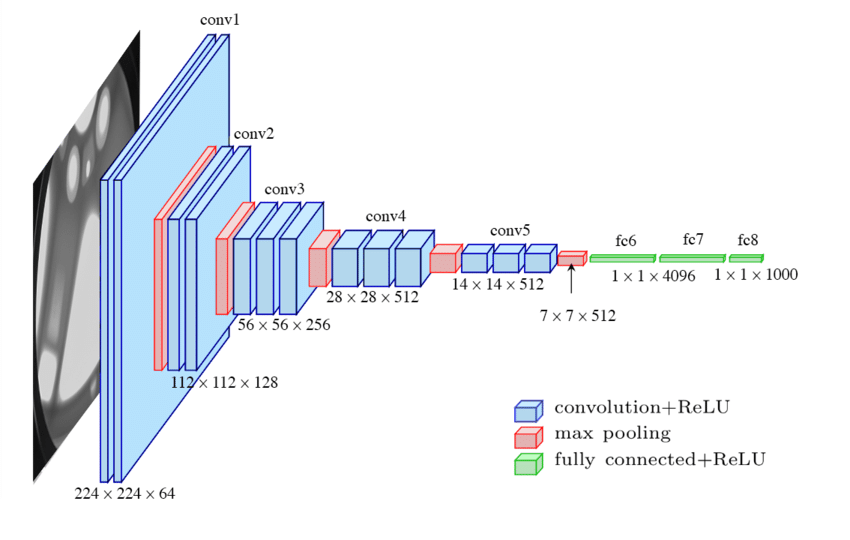

VGG16 is a convolution neural net (CNN) architecture which was used to win ILSVR(Imagenet) competition in 2014. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.

In [5]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [6]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [7]:
  # useful for getting number of classes
folders = glob('distracted_driver/train/*')

In [8]:
classes = len(folders)
classes

2

In [9]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(1024, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [11]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

In [15]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 15697 images belonging to 2 classes.


In [17]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4484 images belonging to 2 classes.


In [18]:
# fit the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
491/491 [==============================] - 364s 724ms/step - loss: 0.4888 - accuracy: 0.8888 - val_loss: 0.0854 - val_accuracy: 0.9715
Epoch 2/5
491/491 [==============================] - 373s 760ms/step - loss: 0.0704 - accuracy: 0.9754 - val_loss: 0.0375 - val_accuracy: 0.9871
Epoch 3/5
491/491 [==============================] - 382s 779ms/step - loss: 0.0524 - accuracy: 0.9801 - val_loss: 0.0212 - val_accuracy: 0.9922
Epoch 4/5
491/491 [==============================] - 414s 844ms/step - loss: 0.0394 - accuracy: 0.9845 - val_loss: 0.0251 - val_accuracy: 0.9911
Epoch 5/5
491/491 [==============================] - 382s 777ms/step - loss: 0.0313 - accuracy: 0.9891 - val_loss: 0.0192 - val_accuracy: 0.9915


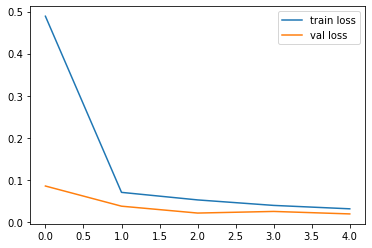

In [19]:
# loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show();

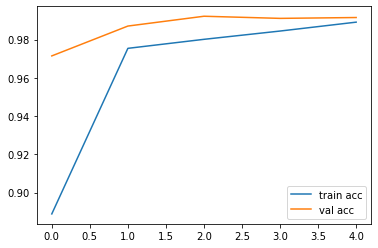

In [20]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show();

In [52]:
test_path = 'distracted_driver/test'

In [53]:
test_datagen2 = ImageDataGenerator(rescale = 1./255)

In [55]:
test_set = test_datagen2.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            shuffle=False,
                                            class_mode = 'categorical')

Found 2244 images belonging to 2 classes.


In [56]:
preds = model.predict(test_set)
preds

array([[9.9862039e-01, 1.3796226e-03],
       [9.9983370e-01, 1.6625359e-04],
       [9.9966300e-01, 3.3703184e-04],
       ...,
       [2.5685249e-06, 9.9999738e-01],
       [2.5839056e-05, 9.9997413e-01],
       [1.2056767e-05, 9.9998796e-01]], dtype=float32)

In [57]:
preds.shape

(2244, 2)

In [58]:
y_pred = []

In [59]:
for i in preds:
    y_pred.append(np.argmax(i))

In [60]:
# evaluate model
_, acc = model.evaluate(test_set)

71/71 [==============================] - 27s 376ms/step - loss: 0.0211 - accuracy: 0.9933


In [61]:
print(f'Accuracy = {round(acc*100, 2)} %' )

Accuracy = 99.33 %


In [96]:
# Finding accuracy using sklearn

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_pred, list(test_set.labels))
print(f'Accuracy = {round(acc*100, 2)} %' )

Accuracy = 99.33 %


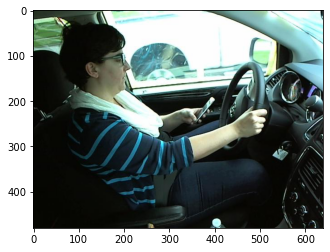

In [79]:
import matplotlib.image as mpimg
sample_test = 'distracted_driver/test/NotSafe/img_5.jpg'
image = mpimg.imread(sample_test)
plt.imshow(image)
plt.show()

In [88]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

#load the image
my_image = load_img(sample_test, target_size=(224, 224))

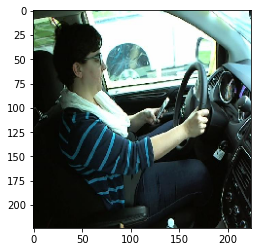

In [92]:
plt.imshow(my_image)
plt.show()

In [93]:
#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

In [100]:
a = np.argmax(model.predict(my_image))

if a == 0:
    print("Not Safe")
else:
    print("Safe")

Not Safe


## 2) Using ResNet50

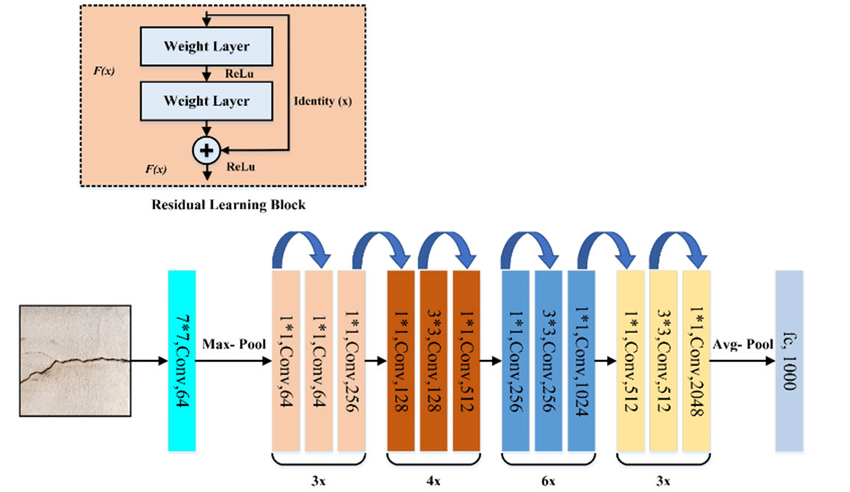

ResNet stands for Residual Network. It is an innovative neural network that was first introduced by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun in their 2015 computer vision research paper titled ‘Deep Residual Learning for Image Recognition’.

This model was immensely successful, as can be ascertained from the fact that its ensemble won the top position at the ILSVRC 2015 classification competition with an error of only 3.57%. Additionally, it also came first in the ImageNet detection, ImageNet localization, COCO detection, and COCO segmentation in the ILSVRC & COCO competitions of 2015.

ResNet has many variants that run on the same concept but have different numbers of layers. **ResNet50** is used to denote the variant that can work with 50 neural network layers.

In [101]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [103]:
resnet50 = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet50.layers:
    layer.trainable = False

In [104]:
# our layers - you can add more if you want
x = Flatten()(resnet50.output)
x = Dense(1024, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)

In [105]:
# create a model object
model = Model(inputs=resnet50.input, outputs=prediction)

In [106]:
# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [107]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [108]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [109]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

In [110]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [111]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 15697 images belonging to 2 classes.


In [112]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4484 images belonging to 2 classes.


In [113]:
# fit the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
491/491 [==============================] - 434s 878ms/step - loss: 1.0516 - accuracy: 0.6548 - val_loss: 0.4082 - val_accuracy: 0.8087
Epoch 2/5
491/491 [==============================] - 403s 820ms/step - loss: 0.4703 - accuracy: 0.7722 - val_loss: 0.3989 - val_accuracy: 0.8051
Epoch 3/5
491/491 [==============================] - 394s 803ms/step - loss: 0.4246 - accuracy: 0.8039 - val_loss: 0.4368 - val_accuracy: 0.7600
Epoch 4/5
491/491 [==============================] - 447s 911ms/step - loss: 0.3704 - accuracy: 0.8385 - val_loss: 0.2591 - val_accuracy: 0.8988
Epoch 5/5
491/491 [==============================] - 462s 941ms/step - loss: 0.3190 - accuracy: 0.8605 - val_loss: 0.4384 - val_accuracy: 0.7864


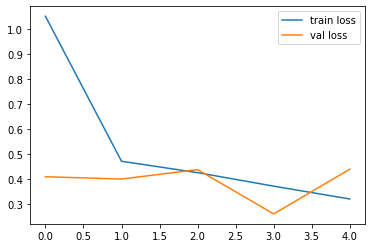

In [114]:
# loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show();

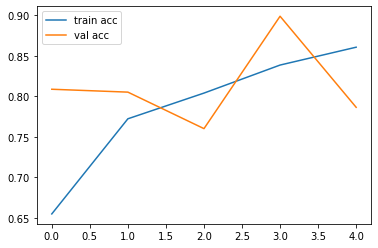

In [115]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show();

In [116]:
test_path = 'distracted_driver/test'

In [117]:
test_datagen2 = ImageDataGenerator(rescale = 1./255)

In [118]:
test_set = test_datagen2.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            shuffle=False,
                                            class_mode = 'categorical')

Found 2244 images belonging to 2 classes.


In [119]:
preds = model.predict(test_set)
preds

array([[0.75902903, 0.24097097],
       [0.93366784, 0.0663321 ],
       [0.20105977, 0.79894024],
       ...,
       [0.2778358 , 0.7221642 ],
       [0.2545138 , 0.7454862 ],
       [0.04516592, 0.9548341 ]], dtype=float32)

In [120]:
preds.shape

(2244, 2)

In [121]:
y_pred = []

In [122]:
for i in preds:
    y_pred.append(np.argmax(i))

In [123]:
# evaluate model
_, acc = model.evaluate(test_set)

71/71 [==============================] - 36s 510ms/step - loss: 0.4139 - accuracy: 0.7879


In [124]:
print(f'Accuracy = {round(acc*100, 2)} %' )

Accuracy = 78.79 %


In [125]:
# Finding accuracy using sklearn

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_pred, list(test_set.labels))
print(f'Accuracy = {round(acc*100, 2)} %' )

Accuracy = 78.79 %


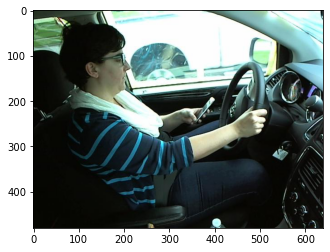

In [133]:
import matplotlib.image as mpimg
sample_test = 'distracted_driver/test/NotSafe/img_5.jpg'
image = mpimg.imread(sample_test)
plt.imshow(image)
plt.show()

In [134]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

#load the image
my_image = load_img(sample_test, target_size=(224, 224))

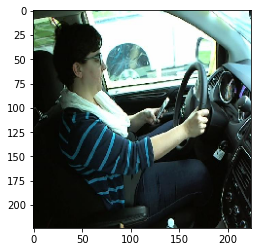

In [135]:
plt.imshow(my_image)
plt.show()

In [136]:
#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

In [137]:
a = np.argmax(model.predict(my_image))

if a == 0:
    print("Not Safe")
else:
    print("Safe")

Not Safe
